In [1]:
%cd /scratch/ejk5818/FLORIDA

/scratch/ejk5818/FLORIDA


In [2]:
from plot_utils import *

# mal pcnt experiment

In [3]:
results_dict = get_mal_pcnt_exp_results()

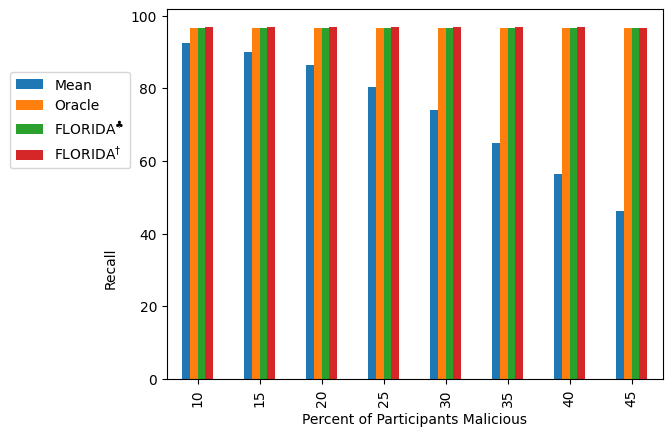

In [14]:
mal_pcnt_df = results_dict['mal_pcnt_df']
mal_pcnt_df = mal_pcnt_df.rename(defense_name_dict, axis=1)
mal_pcnt_df.index = mal_pcnt_df.index * 100
mal_pcnt_df.index.name = 'Percent of Participants Malicious'
mal_pcnt_df.index = mal_pcnt_df.index.astype(int)
ax = mal_pcnt_df.plot.bar()
ax.legend(loc='center left', bbox_to_anchor=(-0.33, 0.7))
ylabel = ax.set_ylabel('Recall')
ax.yaxis.set_label_coords(-0.1, 0.3)

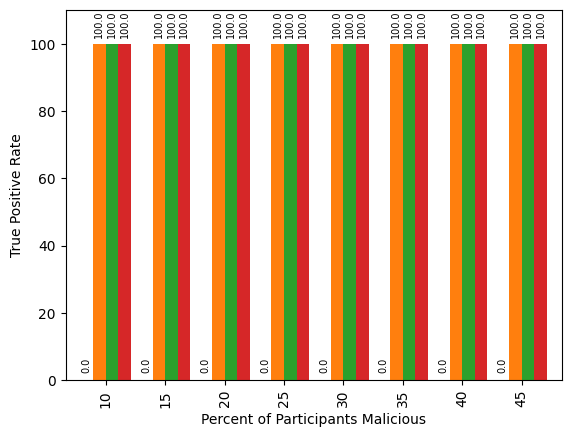

In [4]:
tpr_df = results_dict['tpr_df']
tpr_df = tpr_df.rename(defense_name_dict, axis=1)
tpr_df.index = tpr_df.index * 100
tpr_df.index.name = 'Percent of Participants Malicious'
tpr_df.index = tpr_df.index.astype(int)
ax = tpr_df.plot.bar(width=0.85)
# ax.legend(loc='center left', bbox_to_anchor=(-0.33, 0.7))
ax.legend().remove()
ylabel = ax.set_ylabel('True Positive Rate')
# ax.yaxis.set_label_coords(-0.1, 0.3)
ax.set_ylim(0, 110)
for p in ax.patches:
    value = round(p.get_height(), 2)
    value = float(value)
    ax.annotate(f'{value}', (p.get_x() + p.get_width() / 2, p.get_height() + 2),
                ha='center', va='bottom', rotation=90, fontsize=7)

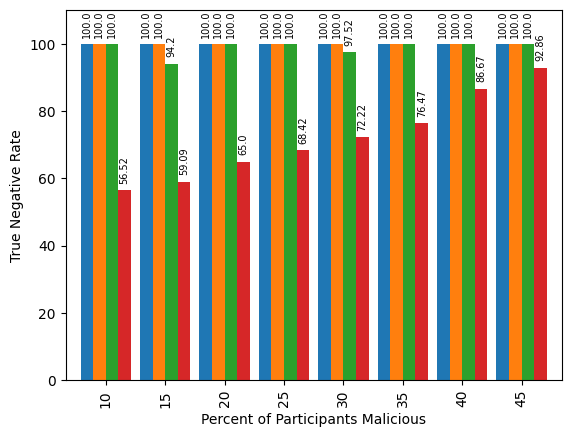

In [5]:
tnr_df = results_dict['tnr_df']
tnr_df = tnr_df.rename(defense_name_dict, axis=1)
tnr_df.index = tnr_df.index * 100
tnr_df.index.name = 'Percent of Participants Malicious'
tnr_df.index = tnr_df.index.astype(int)
ax = tnr_df.plot.bar(width=0.85)
# ax.legend(loc='center left', bbox_to_anchor=(-0.33, 0.7))
ax.legend().remove()
ylabel = ax.set_ylabel('True Negative Rate')
# ax.yaxis.set_label_coords(-0.1, 0.3)
ax.set_ylim(0, 110)
for p in ax.patches:
    value = round(p.get_height(), 2)
    value = float(value)
    ax.annotate(f'{value}', (p.get_x() + p.get_width() / 2, p.get_height() + 2),
                ha='center', va='bottom', rotation=90, fontsize=7)

# non-IID experiment

In [5]:
noniid_results = get_noniid_exp_results()

<Axes: >

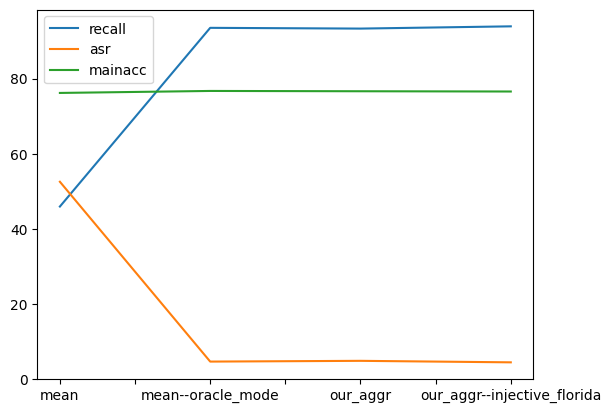

In [6]:
noniid_one_class_expert_df = pd.DataFrame(noniid_results['one_class_expert']).T
noniid_one_class_expert_df.plot()

<Axes: >

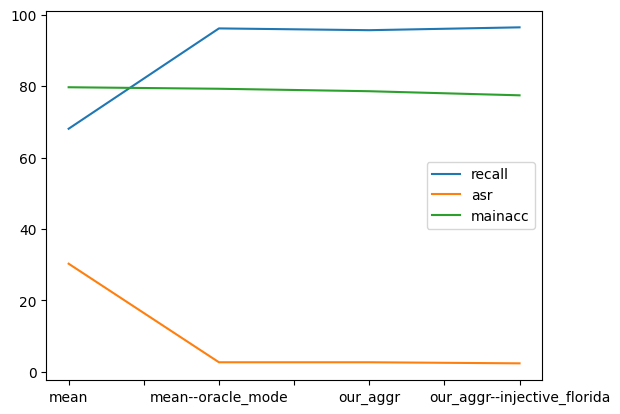

In [7]:
noniid_sampling_dirichlet_df = pd.DataFrame(noniid_results['sampling_dirichlet']).T
noniid_sampling_dirichlet_df.plot()

# mal val type experiment

In [3]:
final_result, avg_tpr, avg_tnr = get_mal_val_type_results()

In [7]:
cluster_final_result = final_result['our_aggr']
cluster_final_result_df = pd.DataFrame(cluster_final_result)
print(cluster_final_result_df.to_latex())

\begin{tabular}{lrrr}
\toprule
 & None & naive & adaptive \\
\midrule
targeted_label_flip & 79.300000 & 79.100000 & 79.300000 \\
dba & 1.733333 & 2.466667 & 1.722222 \\
\bottomrule
\end{tabular}



In [8]:
bijective_final_result = final_result['our_aggr--injective_florida']
bijective_final_result_df = pd.DataFrame(bijective_final_result)
print(bijective_final_result_df.to_latex())

\begin{tabular}{lrrr}
\toprule
 & None & naive & adaptive \\
\midrule
targeted_label_flip & 83.600000 & 83.400000 & 82.000000 \\
dba & 1.688889 & 1.866667 & 1.477778 \\
\bottomrule
\end{tabular}



In [9]:
cluster_tpr = avg_tpr['our_aggr']
cluster_tpr_df = pd.DataFrame(cluster_tpr)
print(cluster_tpr_df.to_latex())

\begin{tabular}{lrrr}
\toprule
 & None & naive & adaptive \\
\midrule
targeted_label_flip & 1.000000 & 1.000000 & 1.000000 \\
dba & 1.000000 & 0.900000 & 1.000000 \\
\bottomrule
\end{tabular}



In [10]:
bijective_tpr = avg_tpr['our_aggr--injective_florida']
bijective_tpr_df = pd.DataFrame(bijective_tpr)
print(bijective_tpr_df.to_latex())

\begin{tabular}{lrrr}
\toprule
 & None & naive & adaptive \\
\midrule
targeted_label_flip & 0.866667 & 0.866667 & 0.866667 \\
dba & 0.866667 & 0.866667 & 0.866667 \\
\bottomrule
\end{tabular}



In [11]:
cluster_tnr = avg_tnr['our_aggr']
cluster_tnr_df = pd.DataFrame(cluster_tnr)
print(cluster_tnr_df.to_latex())

\begin{tabular}{lrrr}
\toprule
 & None & naive & adaptive \\
\midrule
targeted_label_flip & 0.910000 & 0.907500 & 0.907500 \\
dba & 1.000000 & 0.900000 & 1.000000 \\
\bottomrule
\end{tabular}



In [12]:
bijective_tnr = avg_tnr['our_aggr--injective_florida']
bijective_tnr_df = pd.DataFrame(bijective_tnr)
print(bijective_tnr_df.to_latex())

\begin{tabular}{lrrr}
\toprule
 & None & naive & adaptive \\
\midrule
targeted_label_flip & 1.000000 & 1.000000 & 1.000000 \\
dba & 1.000000 & 1.000000 & 1.000000 \\
\bottomrule
\end{tabular}



# contrib adjustment experiment

In [3]:
final_perf_tpr_tnr = get_contrib_adj_results()

In [4]:
plot_df = lambda dict_, key: pd.DataFrame.from_dict(dict_[key], orient='index').T

<Axes: >

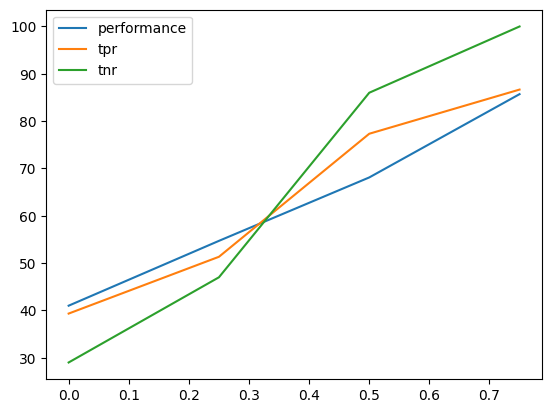

In [5]:
plot_df(final_perf_tpr_tnr, 'targeted_label_flip').plot()

<Axes: >

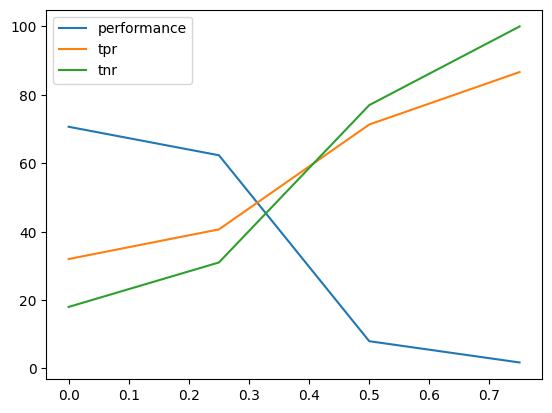

In [6]:
plot_df(final_perf_tpr_tnr, 'dba').plot()

# Adversarial contribution in ensemble model vs LIPC score

<Axes: xlabel='adv_contrib', ylabel='score'>

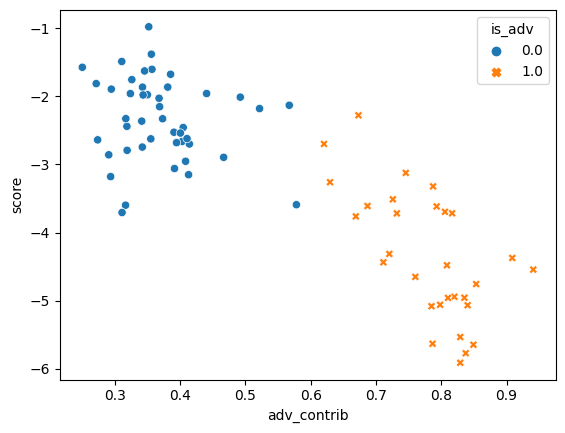

In [3]:
adv_contrib_vs_score_df = get_adv_contrib_vs_score()
sns.scatterplot(x='adv_contrib', y='score', style='is_adv', hue='is_adv', data=adv_contrib_vs_score_df)

# Ablation Aggregate Ensemble

In [9]:
aggregate_ensemble_result_df = get_ablation_aggregate_ensemble_results()
aggregate_ensemble_result_df['mean_sneak_contribs'] = aggregate_ensemble_result_df['mean_sneak_contribs'] * 100

In [10]:
print(aggregate_ensemble_result_df.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrr}
\toprule
 & mean_sneak_contribs & avg_tpr & avg_tnr & final_result \\
\midrule
True & 8.60 & 99.00 & 86.00 & 51.00 \\
False & 0.00 & 100.00 & 86.67 & 0.43 \\
\bottomrule
\end{tabular}



# Ablation Clustering Comparison

In [5]:
cluster_results_df = get_cluster_comparison_results()

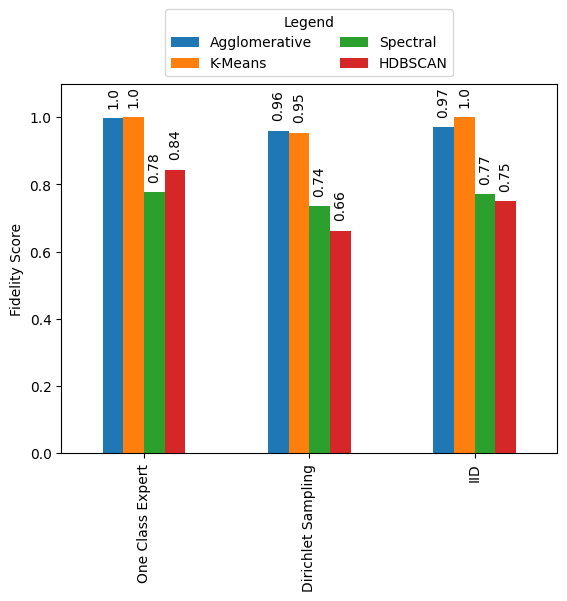

In [19]:
ax = cluster_results_df.plot.bar()
ax.set_ylabel('Fidelity Score')
ax.legend(title='Legend', loc='upper center', bbox_to_anchor=(0.5, 1.22), ncol=2)
for p in ax.patches:
    value = round(p.get_height(), 2)
    ax.annotate(f'{value}', (p.get_x() + p.get_width() / 2, p.get_height() + 0.03),
                ha='center', va='bottom', rotation=90)
ax.set_ylim(0, 1.1)
plt.savefig('../FLORIDA_figures/cluster_comparison.pdf', bbox_inches='tight')


In [5]:
cluster_results_n_cluster_2_df = get_cluster_comparison_n_cluster_2_results()

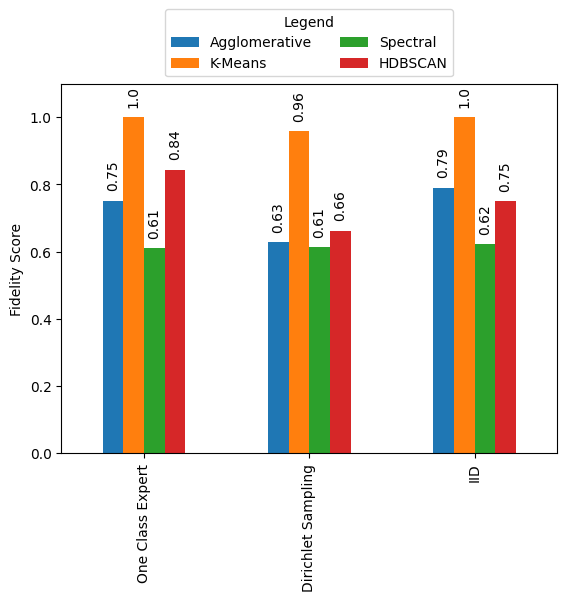

In [7]:
ax = cluster_results_n_cluster_2_df.plot.bar()
ax.set_ylabel('Fidelity Score')
ax.legend(title='Legend', loc='upper center', bbox_to_anchor=(0.5, 1.22), ncol=2)
for p in ax.patches:
    value = round(p.get_height(), 2)
    ax.annotate(f'{value}', (p.get_x() + p.get_width() / 2, p.get_height() + 0.03),
                ha='center', va='bottom', rotation=90)
ax.set_ylim(0, 1.1)
plt.savefig('../FLORIDA_figures/cluster_comparison_n_cluster_2.pdf', bbox_inches='tight')

# Ablation Imputation Comparison

In [6]:
imputation_dfs = get_imputation_comparison_results()

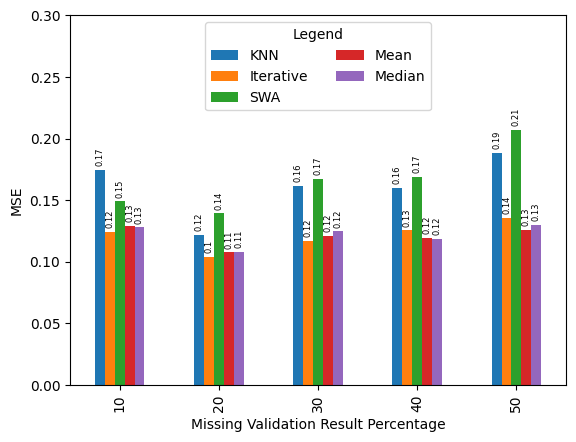

In [39]:
ax = imputation_dfs['False'].plot.bar()
ax.set_ylabel('MSE')
ax.legend(title='Legend', loc='upper center', ncol=2)
for p in ax.patches:
    value = round(p.get_height(), 2)
    ax.annotate(f'{value}', (p.get_x() + p.get_width() / 2, p.get_height() + 0.003),
                ha='center', va='bottom', rotation=90, fontsize=6)
ax.set_ylim(0, 0.3)
ax.set_xlabel('Missing Validation Result Percentage')
plt.savefig('../FLORIDA_figures/ablation_imputation_comparison_iid.pdf', bbox_inches='tight')

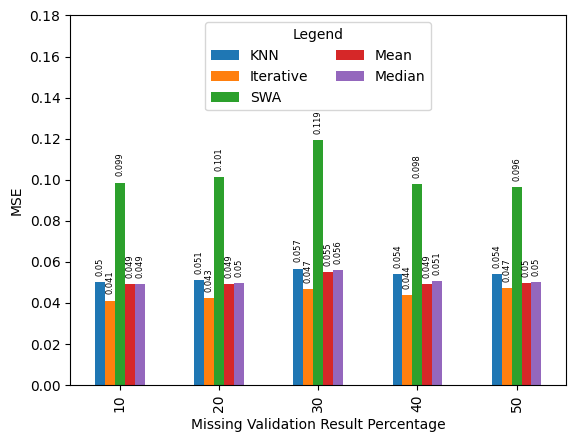

In [38]:
ax = imputation_dfs['one_class_expert'].plot.bar()
ax.set_ylabel('MSE')
# ax.legend(title='Legend', loc='upper center', bbox_to_anchor=(0.5, 1.22), ncol=2)
for p in ax.patches:
    value = round(p.get_height(), 3)
    ax.annotate(f'{value}', (p.get_x() + p.get_width() / 2, p.get_height() + 0.003),
                ha='center', va='bottom', rotation=90, fontsize=6)
ax.set_ylim(0, 0.18)
ax.legend(title='Legend', loc='upper center', ncol=2)
ax.set_xlabel('Missing Validation Result Percentage')
plt.savefig('../FLORIDA_figures/ablation_imputation_comparison_one_class_expert.pdf', bbox_inches='tight')

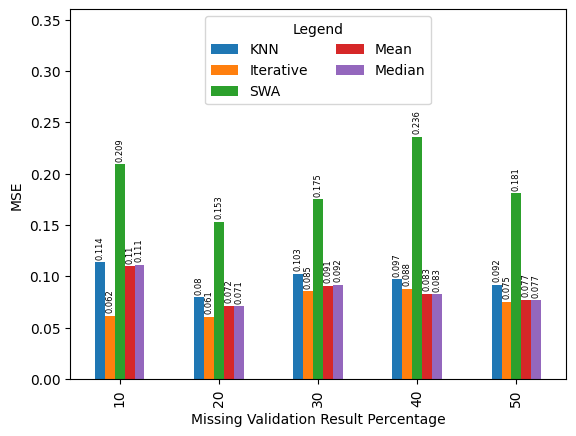

In [43]:
ax = imputation_dfs['sampling_dirichlet'].plot.bar()
ax.set_ylabel('MSE')
# ax.legend(title='Legend', loc='upper center', bbox_to_anchor=(0.5, 1.22), ncol=2)
for p in ax.patches:
    value = round(p.get_height(), 3)
    ax.annotate(f'{value}', (p.get_x() + p.get_width() / 2, p.get_height() + 0.003),
                ha='center', va='bottom', rotation=90, fontsize=6)
ax.set_ylim(0, 0.36)
ax.set_xlabel('Missing Validation Result Percentage')
ax.legend(title='Legend', loc='upper center', ncol=2)
plt.savefig('../FLORIDA_figures/ablation_imputation_comparison_sampling_dirichlet.pdf', bbox_inches='tight')

# Ablation Number of Validators Comparison

In [7]:
num_of_validators_df = get_num_of_validators_results()

In [8]:
print(num_of_validators_df.to_latex(float_format="%.2f"))

\begin{tabular}{lrrr}
\toprule
 & BA & Avg TPR & Avg TNR \\
\midrule
10 & 3.61 & 97.50 & 81.67 \\
15 & 3.46 & 100.00 & 88.89 \\
20 & 2.64 & 100.00 & 83.33 \\
25 & 1.89 & 100.00 & 86.67 \\
\bottomrule
\end{tabular}



# Ablation Validation Metric

In [18]:
filepaths = {
    k: f'saved_results/ablation_validation_metric/validation_metric_{k}_cifar_None_targeted_label_flip' for k in ['accuracy', 'LIPC']
}
epoch_reports = {
    k: get_epoch_reports_json(filepath) for k, filepath in filepaths.items()
}

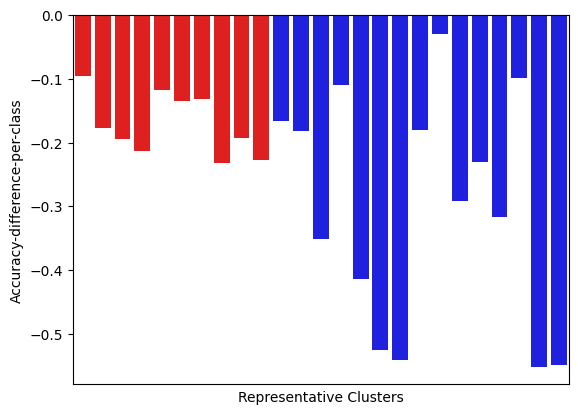

In [37]:
plot_data = [epoch_reports[i]['201']['lowest_score_for_each_cluster'] for i in epoch_reports.keys()]
ax = sns.barplot(x=np.arange(len(plot_data[0])), y=plot_data[0], palette=['red']*10+['blue']*15)
# hide x ticks
ax.set_xticks([])
ax.set_xlabel('Representative Clusters')
ax.set_ylabel('Accuracy-difference-per-class')
plt.savefig('../FLORIDA_figures/ablation_validation_metric_accuracy.pdf', bbox_inches='tight')


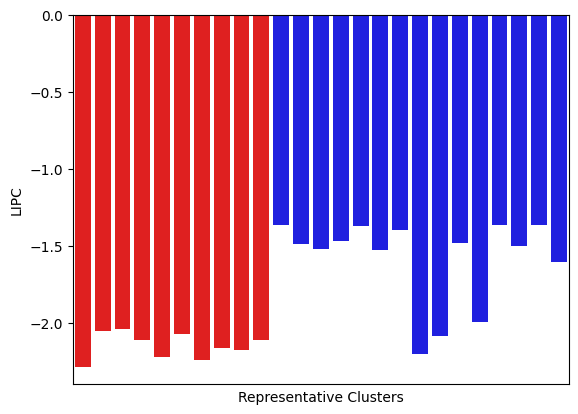

In [38]:
ax = sns.barplot(x=np.arange(len(plot_data[1])), y=plot_data[1], palette=['red']*10+['blue']*15)
# hide x ticks
ax.set_xticks([])
ax.set_xlabel('Representative Clusters')
ax.set_ylabel('LIPC')
plt.savefig('../FLORIDA_figures/ablation_validation_metric_LIPC.pdf', bbox_inches='tight')

In [22]:
epoch_reports['LIPC']['201']['lowest_score_for_each_cluster']

[-2.2841928005218506,
 -2.049067974090576,
 -2.0357015132904053,
 -2.108574390411377,
 -2.22253155708313,
 -2.0718436241149902,
 -2.2389259338378906,
 -2.158672571182251,
 -2.172842264175415,
 -2.108083486557007,
 -1.3623985052108765,
 -1.4857909679412842,
 -1.5216928720474243,
 -1.464468002319336,
 -1.3681330680847168,
 -1.5255517959594727,
 -1.3941326141357422,
 -2.2008209228515625,
 -2.085604190826416,
 -1.483379602432251,
 -1.990478754043579,
 -1.3632057905197144,
 -1.498848557472229,
 -1.3640553951263428,
 -1.6041173934936523]

# Ablation Use Mean

In [5]:
result_dict_df = get_use_mean_results()

In [6]:
print(result_dict_df.to_latex(float_format="%.2f"))

\begin{tabular}{lrrr}
\toprule
 & Recall & TPR & TNR \\
\midrule
True & 73.00 & 80.60 & 73.73 \\
False & 83.60 & 100.00 & 86.67 \\
\bottomrule
\end{tabular}



# Ablation No Detector

In [3]:
result_dict_df = get_no_detector_results()

In [4]:
print(result_dict_df.to_latex(float_format="%.2f"))

\begin{tabular}{lrrr}
\toprule
 & Recall & TPR & TNR \\
\midrule
True & 15.70 & 10.00 & 26.67 \\
False & 83.40 & 100.00 & 86.67 \\
\bottomrule
\end{tabular}



# Adaptive Mal Val Type Loss Plot

In [5]:
import torch

In [7]:
losses = torch.load('cluster_losses.pt').detach().cpu().numpy()

<Axes: >

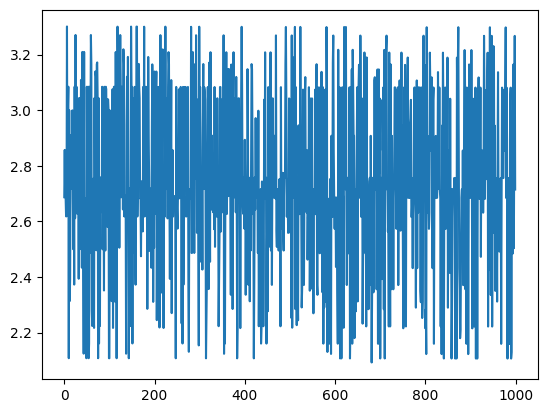

In [9]:
sns.lineplot(x=np.arange(len(losses)), y=losses)